In [72]:
!jupyter nbconvert further-topics-meg-seeg.ipynb --to slides --ServePostProcessor.ip=0.0.0.0 --post serve

[NbConvertApp] Converting notebook further-topics-meg-seeg.ipynb to slides
[NbConvertApp] Writing 333594 bytes to further-topics-meg-seeg.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.1.0
Serving your slides at http://0.0.0.0:8000/further-topics-meg-seeg.slides.html
Use Control-C to stop this server
^C

Interrupted


# Hands-on MEG & sEEG

## TVB Node #5 Marseille

_Marmaduke Woodman_

# Outline

- Softwares, materials, etc
- Data formats & sources, coordinates & transforms
- Run through structural processing
- MEG: gain matrix, simulate evoked responses
- sEEG: gain matrix, simulate
- Discussion

All the materials in this talk are available at 

    https://github.com/the-virtual-brain/tvb-node5/

and these slides are available as an executable, interactive IPython/Jupyter notebook.

The software used in this talk has been packaged as a Docker container, making it available on Windows, macOS, Linux and most cloud providers, with zero installation effort.

Download the image:
```bash
docker pull maedoc/recon
```
and immediately run commands shown in this talk, e.g. FreeSurfers' pipeline
```bash
docker run --rm -it maedoc/recon recon-all ...
```

## Keeping TVB up to date

This container contains a recent clone of TVB's libraries, but let's stay up to date:

In [1]:
!(cd /opt/tvb-library; git checkout trunk; git pull --rebase)

Already on 'trunk'
Your branch is up-to-date with 'origin/trunk'.
remote: Counting objects: 10, done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.
From https://github.com/the-virtual-brain/tvb-library
   6d842d8..c65ba20  trunk      -> origin/trunk
 * [new branch]      sys-stdout -> origin/sys-stdout
First, rewinding head to replay your work on top of it...
Fast-forwarded trunk to c65ba2009c6cc5e50b279e5eadfb5a5522b12c1b.


Just to check, we've also got FreeSurfer, FSL, Mrtrix3, OpenMEEG, MNE available.

In [2]:
!which mri_convert
!which fsl5.0-flirt
!which mrconvert
!which om_assemble
!which mne_watershed_bem

/opt/freesurfer/bin/mri_convert
/usr/bin/fsl5.0-flirt
/opt/mrtrix3/bin/mrconvert
/usr/local/bin/om_assemble
/opt/MNE-2.7.0-3106-Linux-x86_64/bin/mne_watershed_bem


Finally, let's get the modules we'll be using imported:

In [3]:
%pylab inline
from tvb.simulator.lab import *
import nibabel as nb
import mne

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Structural processing


- w/ FreeSurfer (https://surfer.nmr.mgh.harvard.edu)
    - Label T1
    - Extract cortical surfaces
- w/ Mrtrix (http://www.mrtrix.org)
    - Estimate fiber orientations
    - Perform tractography
    - Construct connectome


Invoking the `recon-all` command, 

```bash
recon-all \
    -s ol \
    -i /opt/raw/t1 \
    -all
```

yields verbose output ending with something like 

```
Started at Fri Mar 31 20:11:25 CEST 2017 
Ended   at Sat Apr 1 02:05:45 CEST 2017
#@#%# recon-all-run-time-hours 5.906
recon-all -s ol finished without error at Sat Apr  1 02:05:45 CEST 2017
```

FreeSurfer produces excellent cortical surfaces, but resolution generally too high for simulation or gain matrix calculation:

In [52]:
!mris_info $SUBJECTS_DIR/ol/surf/lh.pial 2>&1 | grep "num vertices"

num vertices: 110721


Downsample via the `fsaverage5` subject, 

In [46]:
%%bash

mri_surf2surf \
    --srcsubject ol \
    --trgsubject fsaverage5 \
    --hemi lh \
    --sval-xyz pial \
    --tval pial.ol \
    --tval-xyz $SUBJECTS_DIR/ol/mri/T1.mgz > /dev/null
    
mris_info $SUBJECTS_DIR/fsaverage5/surf/lh.pial.ol 2>&1 | grep "num vertices"

num vertices: 10242


Diffusion data processing

In [53]:
%%bash
sd=$SUBJECTS_DIR/ol

# estimate fiber orientations
dwi2response tournier $sd/dwi/{raw.mif,response.txt}
dwi2fod csd $sd/dwi/{raw.mif,response.txt} $sd/dwi/fod.mif

# tractography
dwi2mask $sd/dwi/{raw,mask}.mif
tckgen $sd/dwi/{fod.mif,all.tck} -mask $sd/dwi/mask.mif -seed_image $sd/dwi/mask.mif -number 5M

![tracto](img/tracto.png)

Register T1 & diffusion, move ROI image to diffusion space

In [56]:
%%bash

dwiextract -bzero $sd/dwi/{raw.mif,bzero.nii.gz}

flirt -ref $sd/dwi/bzero.nii.gz -in $sd/mri/T1.RAS.nii.gz \
    -omat $sd/dwi/t2d.mat -out $sd/dwi/T1_in_bzero.nii.gz $regopts
    
flirt -applyxfm -interp nearestneighbour -in $sd/mri/aparc+aseg.nii.gz \
    -ref $sd/dwi/bzero.nii.gz -init $sd/dwi/t2d.mat -out $sd/dwi/aa.nii.gz

![coreg-dwi-aa](img/coreg-dwi-aa.png)

Build the connectome

In [ ]:
%%bash
labelconvert $sd/dwi/aa.nii.gz FreeSurferColorLUT.txt fs_default.txt $sd/dwi/label.mif
tck2connectome $sd/dwi/{all.tck,label.mif} counts.txt
tck2connectome $sd/dwi/{all.tck,label.mif} lengths.txt -scale_length -stat_edge mean

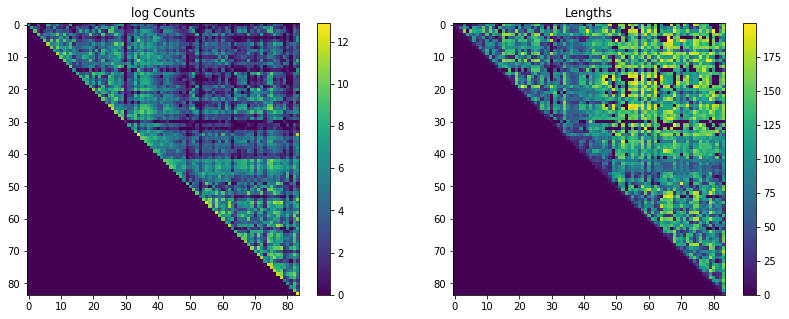

In [69]:
figure(figsize=(14, 5))
dwi_path = '/opt/freesurfer/subjects/ol/dwi/'
subplot(121), imshow(log(loadtxt(dwi_path + 'counts.txt') + 1)), colorbar(), title('log Counts')
subplot(122), imshow(loadtxt(dwi_path + 'lengths.txt')), colorbar(), title('Lengths');

# MEG / EEG

Magneto- and electroencephalography measure the magentic and electric fields generated by **oriented**, dendritic currents in neural populations
![meg00](img/meg00.png)

_Baillet 2017 Nature Nsci_

![meg01](img/meg01.png)

Forward model

1. Source space (e.g. cortical surfaces)
2. Volume conduction (e.g. boundary elements)
3. Sensor space (e.g. MEG sensors)

(1) & (2) are produced from the structural T1, (3) is from the acquisition: another coregistration is required. 

MEG - T1 alignment

![meg-mri-alignment.png](img/meg-mri-alignment.png)

Done w/ `mne_analyze`, but `mne coreg`, Brainstorm are good alternatives

As with the DWI - T1 coregistration, we want to check everything is aligned correctly:

![full-head-model.png](img/full-head-model.png)

# sEEG

Stereo-electroencephalography measures electric fields inside the skull with stereotactic surgically implanted electrodes. 

In Marseille, this is a common intervention for untreatable epilepsy, where the goal is to localize an epileptogenic zone to be removed by surgical resection.

![seeg-schema-front](img/seeg-schema-front.png)

![seeg](img/seeg_tf_pre_ictal2.PNG)

# Discussion

### Topics covered

- Structural processing
- Building a volume conduction model & gain matrix
- Simulating evoked & spontaneous activity in sensor space

### Questions

- How to handle structures without known orientation?
